# **🧙‍♂️ Wizard 🪄**
### Finding the optimized bidding strategy for the card game *Wizard* using a genetic algorithm
##### [Here](https://en.wikipedia.org/wiki/Wizard_(card_game)#Gameplay) are the rules.
---

## 🧬 Part 1, Genetic Algorithm
We're going to use a [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) in order to find the best strategy during the bidding phase of Wizard. 

There are many variables that go into the bidding round, I've defined some important heuristics to start:
- High Card Weight
- Wizard Weight
- Jester Weight
- Trump Weight
- Position Bias
- Risk Bias
- Overbid Penalty Weight


---

### Evolution Summary
This section reports the top-performing genome and how fitness evolved across generations.
- **Generations:** 75  
- **Population size:** 30 bots  
- **Elite count:** Top 10 preserved each generation  
- **Games per bot per generation:** 200  
- **Total evolved games:** ≈ 450,000  
- **Selection criteria:** Bots evaluated by total score over games with randomized player count and 2 fixed baselines



#### Imports:

In [189]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display
sys.path.append("pyFiles")
from genetic import evolve, validate_best_genome
from simulation import validate_probability_player, prob_win

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Run the genetic algorithm:

In [57]:
df_history, best_genome_data = evolve()
print("\n Evolution Complete")


 Evolution Complete


In [58]:
print("\n Best Genome Weights:")
best_genome_series = pd.Series(best_genome_data).round(3).sort_values(key=abs, ascending=False)
print(best_genome_series)


 Best Genome Weights:
wizard_weight             1.312
trump_weight              1.133
risk_bias                -0.887
high_card_weight          0.581
jester_weight            -0.531
overbid_penalty_weight    0.213
position_bias            -0.163
dtype: float64


#### Interpreting this data
| Heuristic | Interpretation |
| ------------------------ | ---------- |
| `trump_weight`           | Trump cards are highly valuable. You should heavily favor bidding **higher** when holding strong trump cards.                  |
| `position_bias`          | If you bid earlier in the turn order, be more conservative. Later players have more information and can bid more aggressively. |
| `wizard_weight`          | Wizards strongly increase your bidding potential. Each one should almost always be worth one trick.                            |
| `high_card_weight`       | High non-trump cards help, but much less than trump or wizards. They're not always reliable for taking tricks.                 |
| `risk_bias`              | A slightly conservative tilt overall — only bid aggressively when you're confident.                                            |
| `jester_weight`          | Jesters have a very mild negative effect. They rarely help win tricks, but don’t drastically hurt your chances either.         |
| `overbid_penalty_weight` | This bot doesn’t fear overbidding much. It slightly favors **aiming for a fair bid** over playing it too safe.                 |


---


### Testing our strategy:

In [59]:
validation_df, bid_freq = validate_best_genome(best_genome_data, games=10000, num_players=5)


 Validation Results:
   Metric  Value
Avg Score   9.08
Hit Bid % 48.77%
    Games  10000

Bid Distribution (out of 10000 rounds):
   Count Percent
0   2852  28.52%
1   2091  20.91%
2   1943  19.43%
3   1663  16.63%
4    991   9.91%
5    373   3.73%
6     77   0.77%
7      9   0.09%
8      1   0.01%


<Axes: title={'center': 'Bid Distribution'}, xlabel='Bid', ylabel='Frequency'>

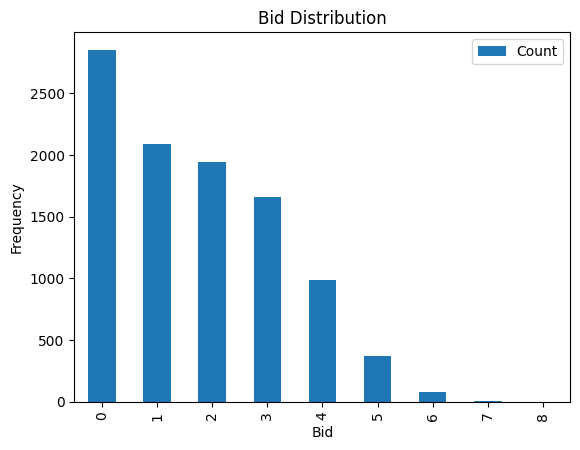

In [60]:
print("\n Validation Results:")
print(validation_df.to_string(index=False))

print("\nBid Distribution (out of 10000 rounds):")
print(bid_freq.to_string())

bid_freq.plot(kind="bar", title="Bid Distribution", xlabel="Bid", ylabel="Frequency")


---
## 🧮 Part 2: Hand Strength Evaluation
### ❓ How can we make this even more accurate?
- We can estimate the probability of each card winning a trick

For small hands (<= 2 cards) we calculate the probabilities, but for larger hands, we run monte carlo-style simulations with random tricks to estimate a probability
For example:

In [72]:
from deck import Card
from simulation import prob_win
import random

hand = [
    Card("Hearts", "Q"),
    Card("Spades", "9"),
    Card("Clubs", "A")
]

trump_suit = "Spades"
num_players = 4
round_number = len(hand)

# Print win probabilities for each card in hand
print(f"Trump Suit: {trump_suit}, Players: {num_players}, Round: {round_number}")
for card in hand:
    p_win = prob_win(card, hand, trump_suit, num_players, round_number)
    print(f"{card}: Estimated win probability = {p_win:.2%}")


Trump Suit: Spades, Players: 4, Round: 3
Q♥️: Estimated win probability = 34.00%
9♠️: Estimated win probability = 54.40%
A♣️: Estimated win probability = 36.80%


In [177]:
hand = [
    Card("Hearts", "Q"),
    Card("Spades", "9"),
    Card("Clubs", "A"),
    Card("Diamonds", "K"),
    Card("Hearts", "2"),
    Card("Spades", "5"),
    Card("Clubs", "3"),
]

trump_suit = "Spades"
num_players = 5
round_number = len(hand)

print(f"Trump Suit: {trump_suit}, Players: {num_players}, Round: {round_number}")
for card in hand:
    p_win = prob_win(card, hand, trump_suit, num_players, round_number)
    print(f"{card}: Estimated win probability = {p_win:.2%}")

Trump Suit: Spades, Players: 5, Round: 7
Q♥️: Estimated win probability = 22.50%
9♠️: Estimated win probability = 50.40%
A♣️: Estimated win probability = 26.90%
K♦️: Estimated win probability = 23.70%
2♥️: Estimated win probability = 7.00%
5♠️: Estimated win probability = 35.50%
3♣️: Estimated win probability = 8.00%


If you run the simulation multiple times for the same hand, you'll notice that the probabilites differ slightly, but are always within a few percentages of one another. 

### Visualization across ranks:

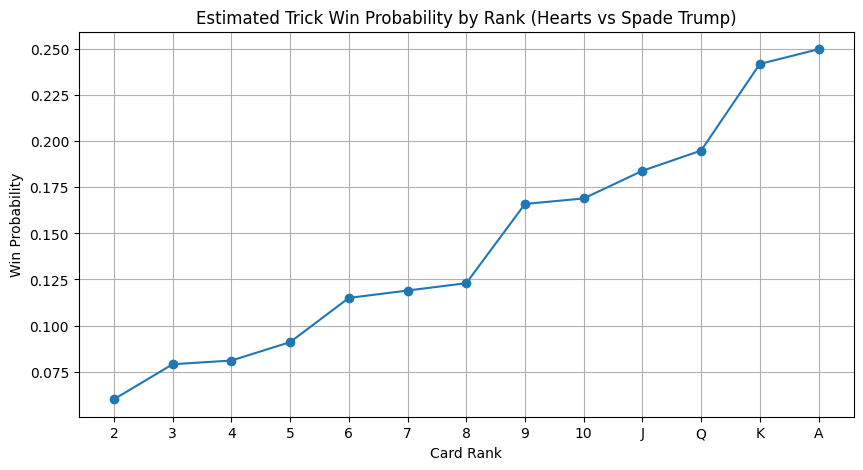

In [150]:
suit = "Hearts"
hand = [Card(suit, rank) for rank in Deck.ranks if rank not in ('W', 'E')]

probs = [
    prob_win(card, hand, trump_suit="Spades", num_players=5, round_number=5)
    for card in hand
]

plt.figure(figsize=(10, 5))
plt.plot(Deck.ranks[:-2], probs, marker='o')
plt.title("Estimated Trick Win Probability by Rank (Hearts vs Spade Trump)")
plt.xlabel("Card Rank")
plt.ylabel("Win Probability")
plt.grid(True)
plt.show()

#### Now to create a bidding strategy, we can sum the probabilities of each card in our hand:

In [193]:
summary, bid_distribution = validate_probability_player(games=100, num_players=5)


 Validation Results:
   Metric  Value
Avg Score   7.18
Hit Bid % 41.00%
    Games    100

Bid Distribution (out of 100 rounds):
   Count Percent
0      9    9.0%
1     35   35.0%
2     24   24.0%
3     15   15.0%
4      8    8.0%
5      1    1.0%
6      7    7.0%
7      1    1.0%


<Axes: title={'center': 'Bid Distribution'}, xlabel='Bid', ylabel='Frequency'>

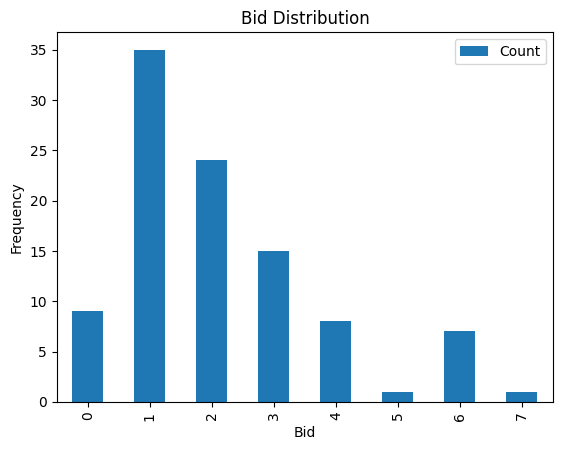

In [194]:
print("\n Validation Results:")
print(summary.to_string(index=False))

print("\nBid Distribution (out of 100 rounds):")
print(bid_distribution.to_string())

bid_distribution.plot(kind="bar", title="Bid Distribution", xlabel="Bid", ylabel="Frequency")